In [1]:
import requests
import json
import time
import re
import random
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sanzharsai\AppData\Roaming\nltk_data...


**Data Collection**

**LLM**

In [2]:
API_KEY = "SB7RLl13RiALifpPVLXfK3jAfXxiqAwO"
# svPU7ggOb1jfTScqf3F4f6CXjaPni13C

# Base URL for Mistral's OpenAI-compatible chat completions endpoint
API_URL = "https://api.mistral.ai/v1/chat/completions"

# Choose one of the available models (e.g., 'mistral-tiny', 'mistral-small', 'mistral-medium')
MODEL = "mistral-small"

# Headers for authentication and content type
HEADERS = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

In [3]:
def chat_with_mistral(messages):
    """
    Sends a list of messages to the Mistral chat API and returns the assistant's response.

    Parameters:
        messages (list): A list of message dictionaries in the OpenAI chat format.
                         Example: [{"role": "user", "content": "Hello!"}]

    Returns:
        str: The assistant's reply as a string.
    """
    payload = {
        "model": MODEL,
        "messages": messages,
        "temperature": 0.7,     # Creativity level (0 = deterministic, 1 = more random)
        "top_p": 1.0,           # Nucleus sampling parameter
        "stream": False         # Disable streaming for simple usage
    }

    # Send a POST request to Mistral's API
    response = requests.post(API_URL, headers=HEADERS, data=json.dumps(payload))

    return response

In [7]:
# a function to save the response to a file
def save_response_to_file(response, filename="response.txt"):
    with open(filename, "a") as file:
        file.write(response + "\n")
    # print(f"Response saved to {filename}")

In [9]:
# Load the common adjectives from a JSON file
with open(r"C:\Users\Sanzharsai\Downloads\common-adjectives.json", "r") as file:
    data = json.load(file)

In [10]:
# Print the number of common adjectives as base words
print(len(data['CommonAdjectives']))

240


In [11]:
def generate_data(prompt):
    # Initialize a conversation with a greeting
    examples = [
        "happy → joyful,content,pleased",
        "sad → unhappy,dejected,downcast",
        "fast → quick,swift,rapid",
    ]
    example = random.choice(examples)
    
    chat_history = [
        {"role": "user", 
         "content": (
             f"Generate only 3 to 10 synonyms for the word '{prompt}' as a single comma-separated string. "
             f"Do not add explanations, greetings, or anything else — only return the synonyms in this exact format: word1,word2,word3. "
             f"Example: {example}. No brackets, no quotes, no extra text, no whitespace between the first word and the second word except the comma. Just synonyms."
         )
        }
    ]

    try:
        # Send the message and receive the model's response
        return chat_with_mistral(chat_history)

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [12]:

def fetch_with_retry(word, retries=3, delay=2):
    for i in range(retries):
        # Call the function to generate data
        response = generate_data(word)

        if response.status_code == 200:
            response_data = response.json()
            return response_data['choices'][0]['message']['content']
        elif response.status_code == 429:
            wait_time = delay * (2 ** i)
            print(f"Rate limited on '{word}'. Waiting {wait_time}s...")
            time.sleep(wait_time)
        else:
            print(f"Error fetching synonyms for '{word}': {response.status_code} - {response.text}")
            return None
    return None

In [13]:
# List to store failed words when fetching synonyms
failed_words = []

In [14]:
def generate_words_from_base_words(base_words):
    # Generate 3-10 synonyms for each word in the list
    # base_words = data['CommonAdjectives']
    # # base_words = extended_words
    
    for word in base_words:
        prompt = f"{word}"
        response = fetch_with_retry(prompt, retries=2, delay=2)
        
        if response is None:
            print(f"Failed to fetch synonyms for '{word}' after retries.")
            continue
        # break
        if re.match(r"^[a-zA-Z-]+(,[a-zA-Z-]+){1,9}$", response):
            for synonym in response.split(","):
                save_response_to_file(word + "," + synonym.strip(), "synonyms.csv")
            print(f"{word}: {synonym.strip()}")
        else:
            print(f"Invalid response format for '{word}': {response}")
            failed_words.append(word)
            continue

In [15]:
# Generate synonyms for the common adjectives
generate_words_from_base_words(data['CommonAdjectives'])

good: desirable
new: nascent
first: natal
Invalid response format for 'last': final,ultimate,conclude,terminate,end,complete,close,close out
Rate limited on 'long'. Waiting 2s...
Invalid response format for 'long': extended, prolonged, continuous, lasting, enduring, protracted, drawn-out, unending
Rate limited on 'great'. Waiting 2s...
great: significant
little: slender
Invalid response format for 'own': possess,have,hold,retain,control

(Note: I am a text-based AI model and do not have the ability to generate examples in real-time. I provided the synonyms for the word 'own' in the requested format.)
Rate limited on 'other'. Waiting 2s...
Invalid response format for 'other': alternate,different,second,various,distinct,further,separate,diverse

Please note that these are just a few synonyms for the word 'other'. There are many more possible synonyms based on context, so I recommend consulting a thesaurus for a more comprehensive list.
Rate limited on 'old'. Waiting 2s...
old: worn-out
r

In [16]:
import os
os.getcwd()

'c:\\Users\\Sanzharsai\\Downloads'

In [17]:
# Load the synonyms from the CSV file
synonyms_df = pd.read_csv(r"C:\Users\Sanzharsai\Downloads\synonyms.csv", header=None)
synonyms_df.columns = ["word", "synonym"]
synonyms_df = synonyms_df.drop_duplicates()

unique_synonyms = synonyms_df['synonym'].drop_duplicates().reset_index(drop=True)

In [20]:
# Save the DataFrame to a CSV file
unique_synonyms.to_csv("base_synonyms_extended.csv", index=False)

In [21]:
# number of base words
print(f"Number of base words: {len(data['CommonAdjectives'])}")
# number of unique synonyms
print(f"Number of extended base words: {len(unique_synonyms)}")

Number of base words: 240
Number of extended base words: 938


In [22]:
# generate synonyms for the unique synonyms to expand our dataset
generate_words_from_base_words(unique_synonyms)

excellent: top-notch
fantastic: wonderful
Rate limited on 'wonderful'. Waiting 2s...
wonderful: magnificent
superb: admirable
Rate limited on 'great'. Waiting 2s...
great: sizeable
Invalid response format for 'noble': distinguished, illustrious, high-minded, honorable, prestigious, revered, exalted, virtuous
Rate limited on 'meritorious'. Waiting 2s...
meritorious: worthy
desirable: admirable
fresh: restored
original: preceding
Invalid response format for 'innovative': groundbreaking, original, revolutionary, pioneering, creative, inventive, novel, fresh

(Please note that these are some of the synonyms for the word 'innovative' and there are many more possibilities based on context.)
inaugural: startup
unseen: unrecognized
Rate limited on 'nascent'. Waiting 2s...
Invalid response format for 'nascent': emerging,developing,blooming, budding,growing,young,fledgling,inceptive
primary: preliminary
initial: commencing
foremost: paramount
preceding: prevasive
Invalid response format for 'ear

In [23]:
base_synonyms=pd.read_csv(r"C:\Users\Sanzharsai\Downloads\base_synonyms_extended.csv")

In [51]:
base_synonyms

,synonym
0,excellent
1,fantastic
2,wonderful
3,superb
4,great
...,...
933,acid
934,bitter
935,acrid
936,pungent


**WordNet**

In [24]:
# example of using WordNet to find synonyms
synonyms = set()
for syn in wn.synsets("evil", ):
    for lemma in syn.lemmas():
        synonyms.add(lemma.name())
print(synonyms)

{'malevolent', 'evil', 'vicious', 'malign', 'iniquity', 'malefic', 'evilness', 'immorality', 'wickedness'}


In [25]:
def collect_synonyms_wordnet(word, pos=wn.ADJ, max_words=10):
    """
    Create an edge list for a given word using WordNet.
    """
    synonyms = set()
    # Get the synsets for the word
    synsets = wn.synsets(word, pos=pos)
    for synset in synsets:
        for lemma in synset.lemmas():
            if lemma.name() != word:
                synonyms.add(lemma.name().strip().replace('_', '-').lower())
                print(f"{word}: {lemma.name().strip()}")

                if len(synonyms) >= max_words:
                    # Save the synonyms to a CSV file
                    for synonym in synonyms:
                        save_response_to_file(word + "," + synonym.strip(), "synonyms_wordnet.csv")
                        print(f"{word}: {synonym.strip()}")
                    return

    if synonyms is not None:
        # If we reach here, the num of synonyms is less than max_words so we save them
        for synonym in synonyms:
            save_response_to_file(word + "," + synonym.strip(), "synonyms_wordnet.csv")
            print(f"{word}: {synonym.strip()}") 

In [26]:
# List of words to process
words_for_wordnet = pd.read_csv(r"C:\Users\Sanzharsai\Downloads\synonyms.csv", header=None, names=["word", "synonym"])['word'].drop_duplicates().reset_index(drop=True)

# Generate synonyms for the unique words using WordNet
words_for_wordnet.apply(lambda x: collect_synonyms_wordnet(x, pos=wn.ADJ))

good: full
good: estimable
good: honorable
good: respectable
good: beneficial
good: just
good: upright
good: adept
good: expert
good: practiced
good: adept
good: upright
good: just
good: full
good: estimable
good: honorable
good: respectable
good: practiced
good: beneficial
good: expert
new: fresh
new: novel
new: raw
new: unexampled
new: newfangled
new: New
new: Modern
new: New
new: young
new: unexampled
new: novel
new: modern
new: fresh
new: raw
new: newfangled
new: new
new: young
first: 1st
first: inaugural
first: initiative
first: initiatory
first: maiden
first: beginning
first: foremost
first: world-class
first: 1st
first: maiden
first: world-class
first: inaugural
first: beginning
first: initiative
first: foremost
first: initiatory
great: outstanding
great: bang-up
great: bully
great: corking
great: cracking
great: dandy
great: groovy
great: keen
great: neat
great: nifty
great: outstanding
great: keen
great: dandy
great: neat
great: corking
great: cracking
great: bang-up
great: bu

0      None
1      None
2      None
3      None
4      None
       ... 
723    None
724    None
725    None
726    None
727    None
Name: word, Length: 728, dtype: object

In [27]:
words_for_wordnet

0         good
1          new
2        first
3        great
4       little
        ...   
723       acid
724     bitter
725      acrid
726    pungent
727    sourish
Name: word, Length: 728, dtype: object

In [28]:
print("Number of unique words to be use as base words for WordNet:", len(words_for_wordnet))

Number of unique words to be use as base words for WordNet: 728


## Build Synonyms Network

In [29]:
# load the synonyms similarity and create network
def load_synonyms_network(file_path):
    G = nx.Graph()

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            if not line or ',' not in line:
                continue

            word1, word2 = line.split(',')
            G.add_edge(word1, word2)
            
    return G

In [30]:
wordnet_file_path = 'synonyms_wordnet.csv'
llm_file_path = 'synonyms.csv'
G_wordnet = load_synonyms_network(wordnet_file_path)
G_llm = load_synonyms_network(llm_file_path)

In [31]:
num_nodes = G_wordnet.number_of_nodes()
num_edges = G_wordnet.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes -1))

print(f'WordNet Network:')
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

print("="*40)

print(f'LLM Network:')
num_nodes = G_llm.number_of_nodes()
num_edges = G_llm.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes -1))
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

WordNet Network:
#Edges: 2477
#Nodes: 2122
Density: 0.0011007025032650026
LLM Network:
#Edges: 5139
#Nodes: 2668
Density: 0.0014444408841698386


In [69]:
import pickle
import networkx as nx

# Save
with open("G_wordnet.pkl", "wb") as f:
    pickle.dump(G_wordnet, f)


with open("G_llm.pkl", "wb") as f:
    pickle.dump(G_llm, f)

In [64]:
def compute_graph_metrics(G):
    metrics = {}

    # Basic metrics
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()
    metrics['density'] = nx.density(G)
    metrics['avg_degree'] = sum(dict(G.degree()).values()) / G.number_of_nodes()

    # Clustering
    metrics['avg_clustering'] = nx.average_clustering(G)

    # Shortest path length and diameter (only for connected graphs)
    if nx.is_connected(G):
        metrics['avg_shortest_path'] = nx.average_shortest_path_length(G)
        metrics['diameter'] = nx.diameter(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc).copy()
        metrics['avg_shortest_path'] = nx.average_shortest_path_length(subgraph)
        metrics['diameter'] = nx.diameter(subgraph)

    # Connected components
    metrics['connected_components'] = nx.number_connected_components(G)

    # Betweenness centrality (average)
    betweenness = nx.betweenness_centrality(G)
    metrics['avg_betweenness'] = sum(betweenness.values()) / len(betweenness)

    return metrics

# Compute metrics
metrics_wordnet = compute_graph_metrics(G_wordnet)
metrics_llm = compute_graph_metrics(G_llm)
print("Metrics for wordnet :")
print(metrics_wordnet)

Metrics for wordnet :
{'num_nodes': 2122, 'num_edges': 2477, 'density': 0.0011007025032650026, 'avg_degree': 2.334590009425071, 'avg_clustering': 0.1935428365502656, 'avg_shortest_path': 10.009057813324048, 'diameter': 24, 'connected_components': 211, 'avg_betweenness': 0.001108021599327836}


In [65]:
print(metrics_llm)

{'num_nodes': 2668, 'num_edges': 5139, 'density': 0.0014444408841698386, 'avg_degree': 3.8523238380809595, 'avg_clustering': 0.19168922556278586, 'avg_shortest_path': 7.041769787999508, 'diameter': 15, 'connected_components': 2, 'avg_betweenness': 0.0022273578793323553}


In [32]:
def visualize_neighborhood_extended(G, word, radius=1, layout='spring', label=None):
    
    if word not in G:
        print(f'The word "{word}" is not in the graph.')
        return

    neighborhood = nx.ego_graph(G, word, radius=radius)

    # Use Seaborn's whitegrid style for a cleaner aesthetic
    sns.set_style("whitegrid")

    plt.figure(figsize=(12, 10))

    # Choose layout
    if layout == 'spring':
        pos = nx.spring_layout(neighborhood, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(neighborhood)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(neighborhood)
    elif layout == 'spectral':
        pos = nx.spectral_layout(neighborhood)
    else:
        pos = nx.spring_layout(neighborhood, seed=42)

    # Node and edge drawing
    nx.draw_networkx_edges(
        neighborhood, pos, connectionstyle='arc3, rad=0.2',
        edge_color='gray', alpha=0.5, arrows=True
    )

    nx.draw_networkx_nodes(
        neighborhood, pos, node_color='#69b3a2',
        node_size=0, edgecolors='black', linewidths=0.8
    )

    nx.draw_networkx_labels(
        neighborhood, pos, font_size=12,
        font_weight='bold', font_color='black'
    )

    plt.axis('off')
    plt.title(
        f"Synonyms Network of '{word}' (radius={radius})" + (f" - {label}" if label else ""),
        fontsize=16, fontweight='bold'
    )
    plt.tight_layout()

    plt.show() 

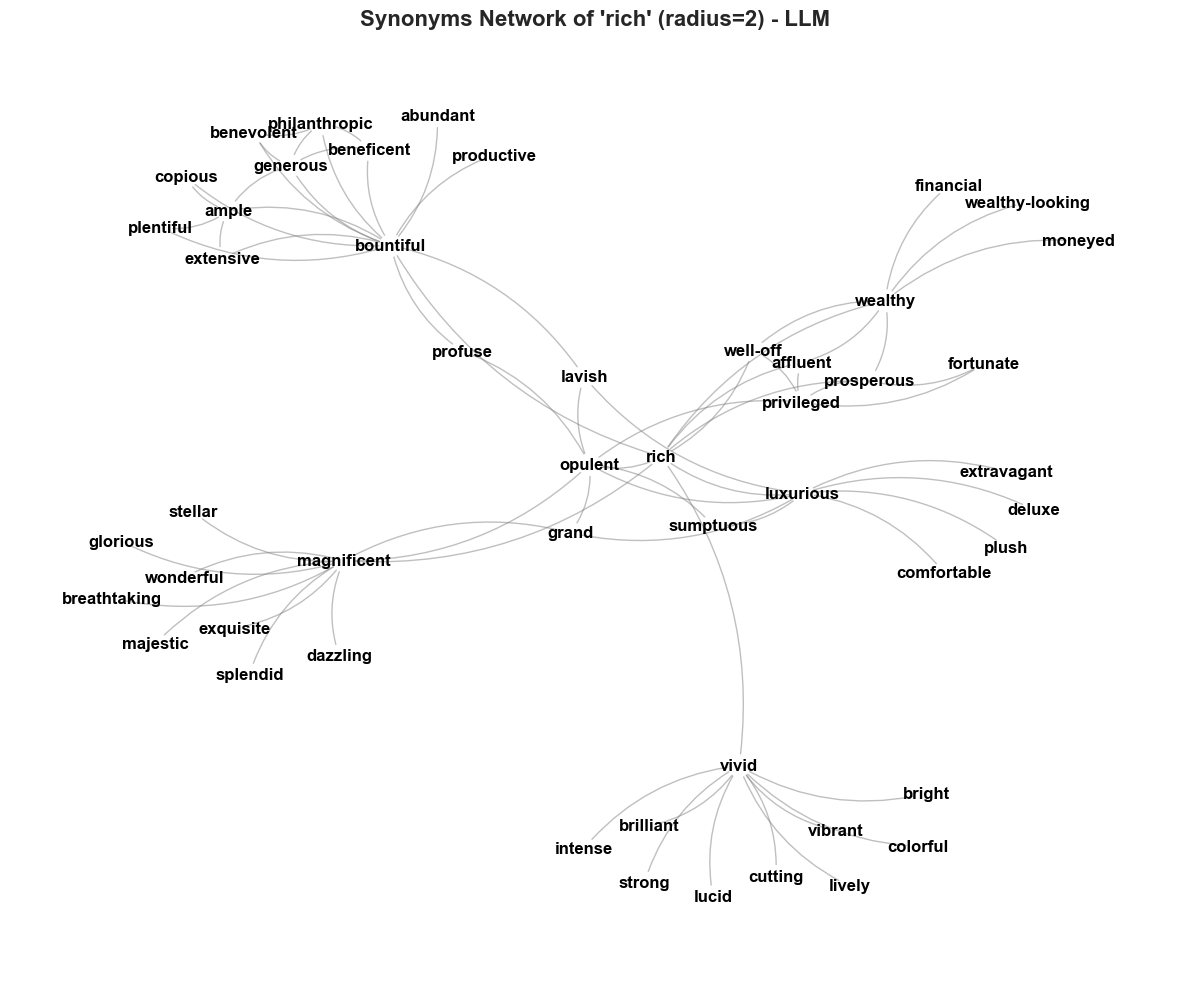

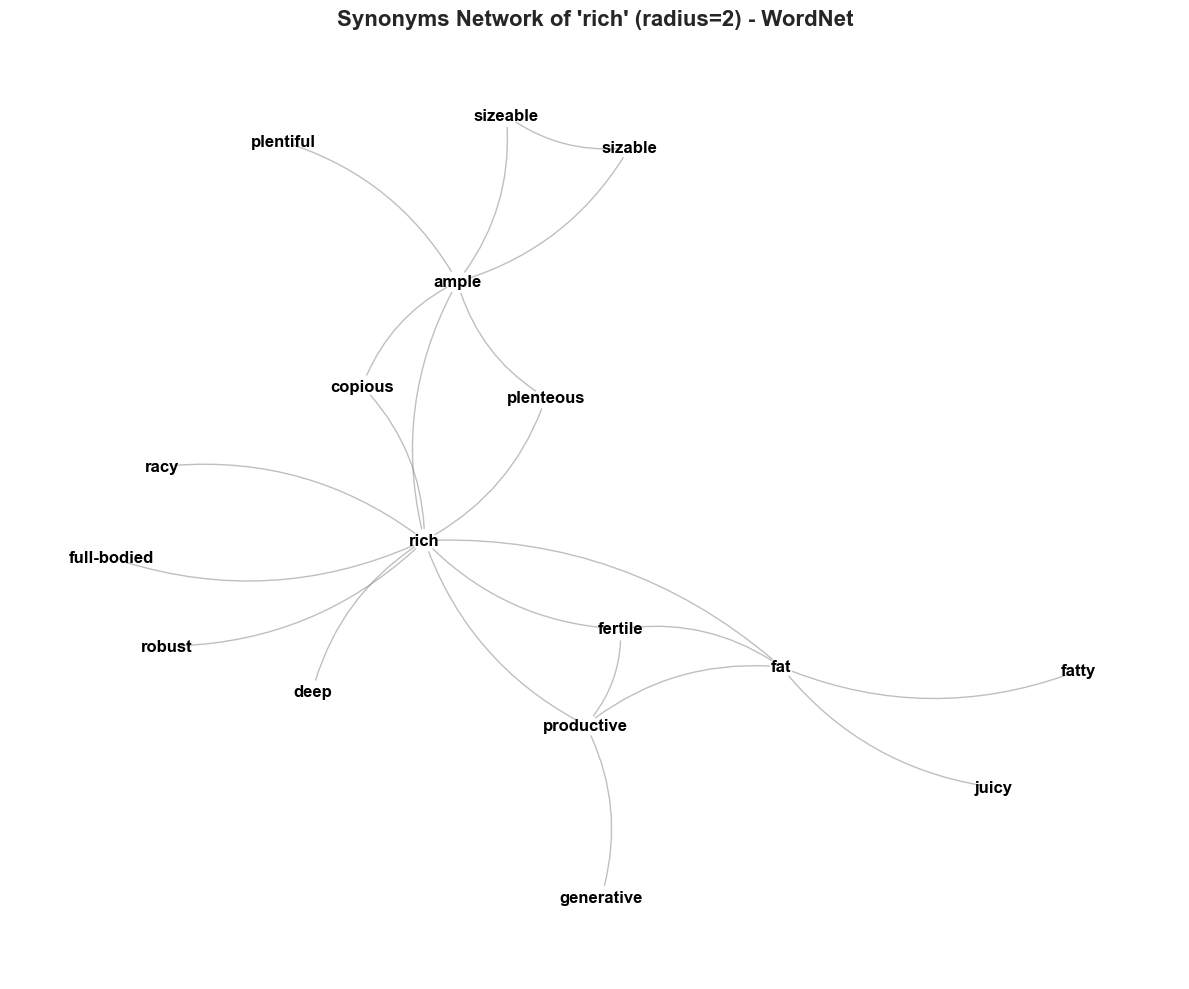

In [62]:
# Visualize the neighborhood of a specific word
word = 'rich'
visualize_neighborhood_extended(G_llm, word, radius=2, label='LLM')
visualize_neighborhood_extended(G_wordnet, word, radius=2, label='WordNet')

In [34]:
degree_llm = dict(G_llm.degree())
degree_wordnet = dict(G_wordnet.degree())


degree_sorted_wordnet = sorted(degree_wordnet.items(), key=lambda x: x[1], reverse=True)
degree_sorted_llm = sorted(degree_llm.items(), key=lambda x: x[1], reverse=True)
top_20_nodes_wordnet = degree_sorted_wordnet[:20]
top_20_nodes_llm = degree_sorted_llm[:20]
print("Top 20 nodes by degree in WordNet:")
print(top_20_nodes_wordnet)
print("Top 20 nodes by degree in LLM:")
print(top_20_nodes_llm)

Top 20 nodes by degree in WordNet:
[('good', 18), ('fresh', 15), ('keen', 12), ('little', 12), ('big', 12), ('heavy', 12), ('open', 12), ('strong', 12), ('hard', 12), ('dark', 12), ('muddy', 12), ('dull', 12), ('false', 12), ('crisp', 12), ('sloppy', 12), ('lofty', 12), ('bad', 11), ('short', 11), ('soft', 11), ('clean', 11)]
Top 20 nodes by degree in LLM:
[('strong', 25), ('original', 20), ('firm', 20), ('primary', 19), ('legitimate', 19), ('generous', 18), ('deceptive', 18), ('significant', 17), ('modest', 17), ('common', 17), ('polished', 17), ('gloomy', 17), ('helpful', 17), ('secure', 17), ('sharp', 17), ('large', 16), ('small', 16), ('perceptive', 16), ('precise', 16), ('distinguished', 16)]


In [35]:
sns.reset_defaults()
plt.style.use('default')

In [36]:
def plot_degree_both_dist(deg_dist_llm, deg_dist_wordnet):
    # sns.set_style("whitegrid")
    plt.figure(figsize=(10, 8))
    plt.plot(range(len(deg_dist_llm)), deg_dist_llm, marker='o', markersize=6)
    plt.plot(range(len(deg_dist_wordnet)), deg_dist_wordnet, marker='o', markersize=6)

    plt.title(f"Wordnet vs LLM Degree Distribution Log-Log")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([1, 25])
    plt.xticks(fontsize=10)
    plt.xlabel("Degree log scale")
    plt.ylabel("Frequency log scale")
    plt.legend(["LLM", "WordNet"], loc='upper right')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [37]:
def plot_degree_dist(deg_dist, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(deg_dist)), deg_dist, marker='o', markersize=6)
    plt.title(f"{title} Degree Distribution Log-Log")
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(fontsize=10)
    plt.xlabel("Degree log scale")
    plt.ylabel("Frequency log scale")
    plt.grid(True, ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

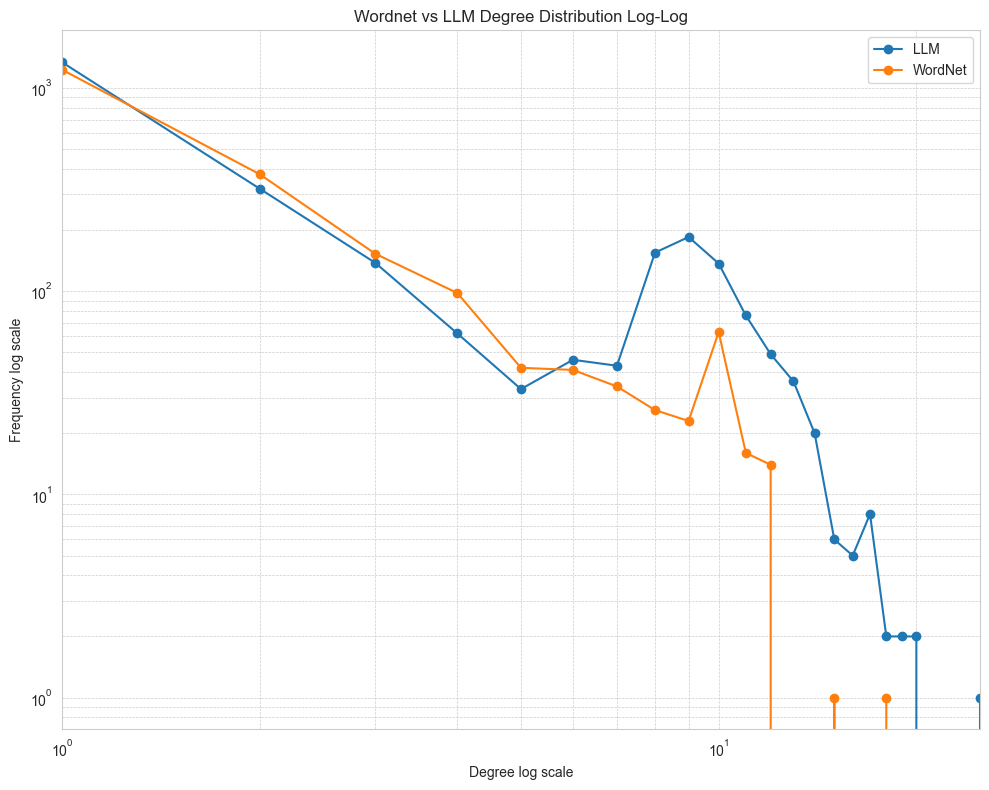

In [66]:
llm_degree_hist = nx.degree_histogram(G_llm)
wordnet_degree_hist = nx.degree_histogram(G_wordnet)
plot_degree_both_dist(llm_degree_hist, wordnet_degree_hist)

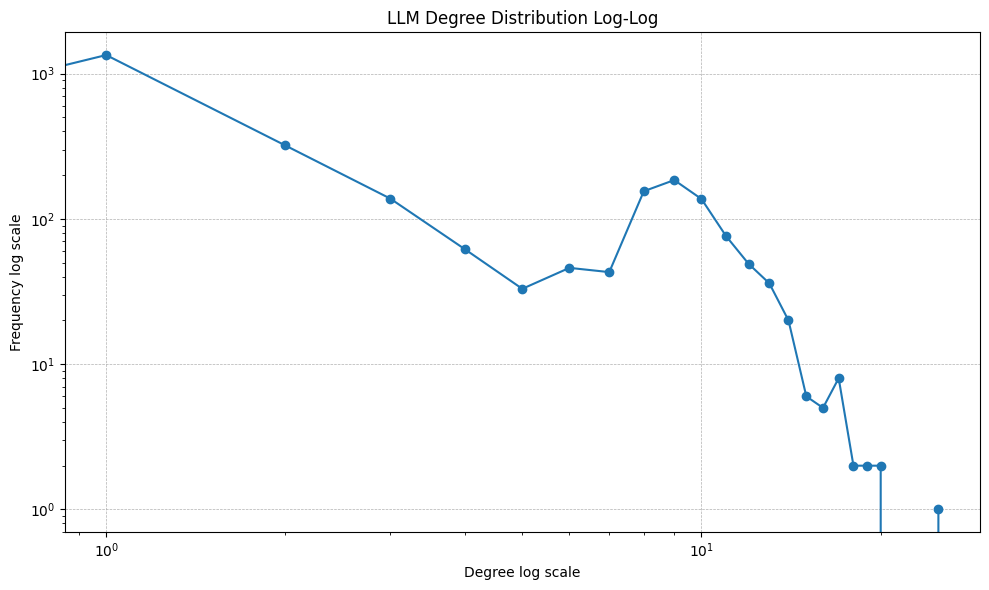

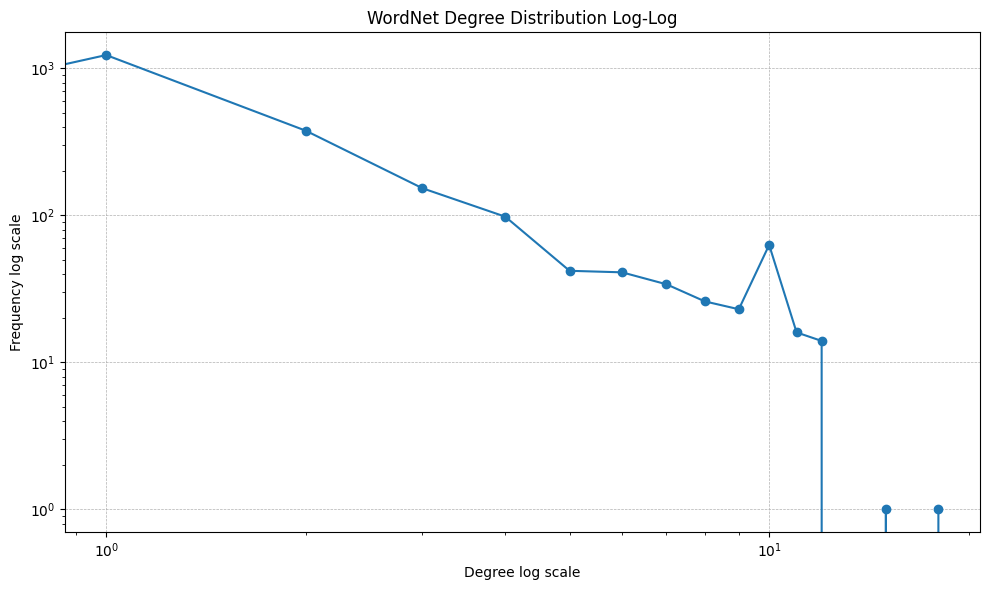

In [39]:
plot_degree_dist(llm_degree_hist, "LLM")
plot_degree_dist(wordnet_degree_hist, "WordNet")

In [40]:
# calculate local clustering coefficient
def calculate_clustering_coefficient(G):
    clustering_coeffs = nx.clustering(G)
    return clustering_coeffs
clustering_coeffs_llm = calculate_clustering_coefficient(G_llm)
clustering_coeffs_wordnet = calculate_clustering_coefficient(G_wordnet)

In [41]:
def get_top_k_nodes_by_clustering(clustering_coeffs, k=10):
    
    sorted_nodes = sorted(clustering_coeffs.items(), key=lambda x: x[1], reverse=True)
    return sorted_nodes[:k]

In [ ]:
print("Top 10 nodes by clustering coefficient:")
top_10_clustering_coeff = get_top_k_nodes_by_clustering(clustering_coeffs_llm, k=10)
print(top_10_clustering_coeff)

top_10_clustering_coeff = get_top_k_nodes_by_clustering(clustering_coeffs_wordnet, k=10)
print(top_10_clustering_coeff)ZW

Top 10 nodes by clustering coefficient:
[('maiden', 1.0), ('diverse', 1.0), ('dissimilar', 1.0), ('spacious', 1.0), ('occasional', 1.0), ('horrible', 1.0), ('widespread', 1.0), ('all-encompassing', 1.0), ('hearty', 1.0), ('one', 1.0)]
[('practiced', 1.0), ('maiden', 1.0), ('world-class', 1.0), ('initiative', 1.0), ('initiatory', 1.0), ('dandy', 1.0), ('corking', 1.0), ('cracking', 1.0), ('bully', 1.0), ('prominent', 1.0)]


In [43]:
# Calculate the average clustering coefficient
average_clustering_coeff = nx.average_clustering(G_wordnet), nx.average_clustering(G_llm)
print(f"Average clustering coefficient (WordNet): {average_clustering_coeff[0]:.4f}")
print(f"Average clustering coefficient (LLM): {average_clustering_coeff[1]:.4f}")
# Calculate the global clustering coefficient
global_clustering_coeff = nx.transitivity(G_wordnet), nx.transitivity(G_llm)
print(f"Global clustering coefficient (WordNet): {global_clustering_coeff[0]:.4f}")
print(f"Global clustering coefficient (LLM): {global_clustering_coeff[1]:.4f}")

Average clustering coefficient (WordNet): 0.1935
Average clustering coefficient (LLM): 0.1917
Global clustering coefficient (WordNet): 0.2110
Global clustering coefficient (LLM): 0.2336


In [44]:
common_nodes = set(G_llm.nodes()).intersection(G_wordnet.nodes())
print("Common nodes:", common_nodes)

Common nodes: {'international', 'desirable', 'frail', 'lone', 'loyal', 'popular', 'exceptional', 'erudite', 'cosy', 'black', 'ordered', 'delicate', 'intermediate', 'foremost', 'myopic', 'high-priced', 'foul', 'unable', 'studious', 'stellar', 'unyielding', 'dynamical', 'impure', 'demoralized', 'hopeful', 'interconnected', 'pretended', 'veracious', 'debonair', 'duplicitous', 'skinny', 'fiery', 'practical', 'flat', 'game', 'old', 'firm', 'burnished', 'permissible', 'average', 'charitable', 'waterless', 'level', 'plucky', 'vital', 'primitive', 'unprocessed', 'stocky', 'unusual', 'ethnic', 'untied', 'physical', 'all-encompassing', 'muddy', 'dim', 'primeval', 'flaming', 'individual', 'cheerful', 'big', 'misleading', 'shadowy', 'departed', 'somber', 'uncomplicated', 'innovative', 'thrifty', 'drab', 'barren', 'wide', 'penetrating', 'fat', 'civic', 'juvenile', 'honest', 'discreet', 'sagacious', 'corporate', 'curt', 'risk-free', 'gracious', 'gallant', 'comfortable', 'conscious', 'usual', 'unlike

In [45]:
G_llm_comm = G_llm.subgraph(common_nodes).copy()
G_wordnet_comm = G_wordnet.subgraph(common_nodes).copy()

In [46]:
disconnected_llm = [node for node in G_llm_comm.nodes if G_llm_comm.degree(node) == 0]
disconnected_wordnet = [node for node in G_wordnet_comm.nodes if G_wordnet_comm.degree(node) == 0]
print(f"Disconnected nodes in LLM: {len(disconnected_llm)}")
print(f"Disconnected nodes in WordNet: {len(disconnected_wordnet)}")

Disconnected nodes in LLM: 39
Disconnected nodes in WordNet: 84


In [47]:
# Create a subgraph excluding nodes in `disconnected_wordnet`
G_wordnet_comm_without_disconnected = G_wordnet_comm.subgraph(
    [n for n in G_wordnet_comm.nodes if n not in disconnected_wordnet]
).copy()

# Create a subgraph excluding nodes in `disconnected_llm`
G_llm_comm_without_disconnected = G_llm_comm.subgraph(
    [n for n in G_llm_comm.nodes if n not in disconnected_llm]
).copy()

In [48]:
num_nodes = G_wordnet_comm_without_disconnected.number_of_nodes()
num_edges = G_wordnet_comm_without_disconnected.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes -1))
print(f'WordNet Network:')
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

print("="*40)

print(f'LLM Network:')
num_nodes = G_llm_comm_without_disconnected.number_of_nodes()
num_edges = G_llm_comm_without_disconnected.number_of_edges()
density = 2 * num_edges / (num_nodes * (num_nodes - 1))
print(f'#Edges: {num_edges}')
print(f'#Nodes: {num_nodes}')
print(f'Density: {density}')

WordNet Network:
#Edges: 1120
#Nodes: 999
Density: 0.0022467357136695815
LLM Network:
#Edges: 2343
#Nodes: 1044
Density: 0.00430345709216341


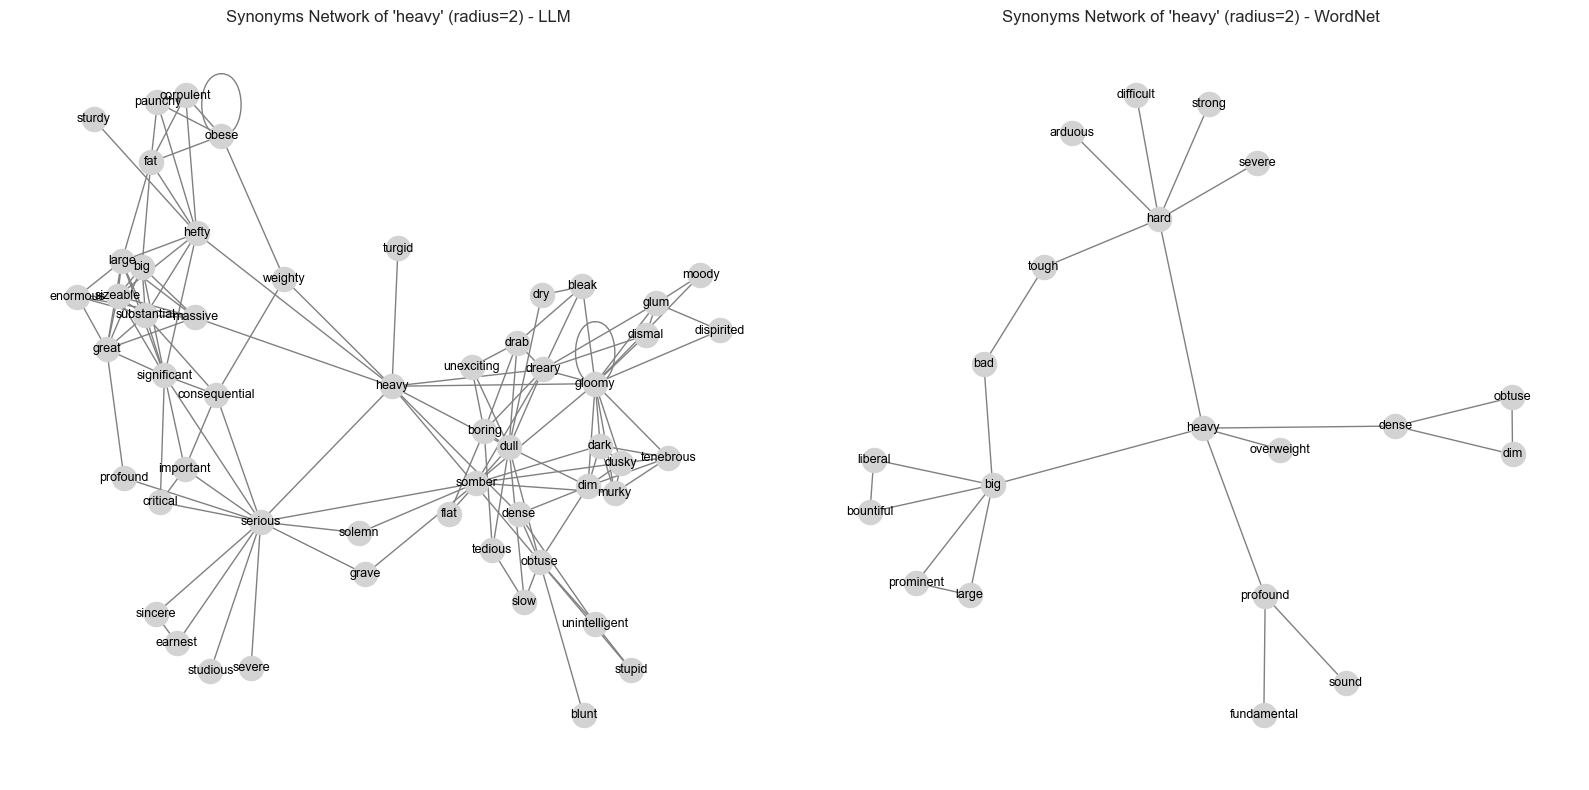

In [67]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_neighborhood_extended_side_by_side(G1, G2, word, radius=2, labels=("LLM", "WordNet")):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # two plots side by side

    for i, (G, label) in enumerate(zip([G1, G2], labels)):
        sub_nodes = nx.ego_graph(G, word, radius=radius)
        pos = nx.spring_layout(sub_nodes, seed=42)

        nx.draw(sub_nodes, pos, ax=axes[i],
                node_size=300,
                node_color="lightgray",
                edge_color="gray",
                with_labels=True,
                font_size=9)
        axes[i].set_title(f"Synonyms Network of '{word}' (radius={radius}) - {label}")

    plt.tight_layout()
    plt.show()

# Call the function
visualize_neighborhood_extended_side_by_side(
    G_llm_comm,
    G_wordnet_comm_without_disconnected,
    word='heavy',
    radius=2,
    labels=("LLM", "WordNet")
)
